In [1]:
import numpy as np
import seaborn as sns
import pylab as pl
import pandas as pd
import sklearn
import sklearn.model_selection, sklearn.svm, sklearn.ensemble
from scipy.spatial.distance import pdist, squareform
import sklearn.manifold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import sklearn.tree, sklearn.linear_model
import bayes_opt
import scipy.stats
import xgboost as xgb
import gc

%matplotlib inline
pl.rcParams['figure.figsize'] = (15,3)
pd.options.display.max_columns = 50
pd.options.display.float_format = lambda x: '%g' % x
pd.DataFrame([[pd.__version__], [np.__version__], [pl.matplotlib.__version__], [sklearn.__version__], [xgb.__version__]],
             columns=['version'], index=['pandas', 'numpy', 'matplotlib', 'sklearn', 'xgboost'])

,version
pandas,0.20.1
numpy,1.12.1
matplotlib,2.0.2
sklearn,0.18.1
xgboost,0.6


## SQL query for CasJobs server

SpecPhoto.csv:
SELECT objid, class, z AS specz, zerr AS specz_err,
  dered_u, dered_g, dered_r, dered_i, dered_z
INTO mydb.SpecPhoto
FROM SpecPhoto
WHERE zerr/(1 + z) BETWEEN 0 and 0.002 AND
  dered_u >= 0 AND dered_g >= 0 AND
  dered_r >= 0 AND dered_i >= 0 AND
  dered_z >= 0 AND zWarning = 0

SpecPhotoJOINPhotoZ.csv:
SELECT sp.objid, sp.class, sp.z AS specz, sp.zerr AS specz_err,
  sp.dered_u, sp.dered_g, sp.dered_r, sp.dered_i, sp.dered_z,
  pz.z AS photoz, pz.zerr AS photoz_err
INTO mydb.SpecPhoto
FROM SpecPhoto sp 
  JOIN PhotoZ pz ON sp.objid = pz.objid
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

SpecPhotoMagsJOINPhotoZ.csv:
SELECT sp.objid, sp.class, sp.z AS specz, sp.zerr AS specz_err,
  sp.dered_u, sp.dered_g, sp.dered_r, sp.dered_i, sp.dered_z,
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z,
  pz.z AS photoz, pz.zerr AS photoz_err
INTO mydb.SpecPhoto
FROM SpecPhoto sp 
  JOIN PhotoZ pz ON sp.objid = pz.objid
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

SpecPhotoMagsLEFTJOINPhotoZ.csv:
SELECT sp.objid, sp.class, sp.z AS specz, sp.zerr AS specz_err,
  sp.dered_u, sp.dered_g, sp.dered_r, sp.dered_i, sp.dered_z,
  pz.z AS photoz, pz.zerr AS photoz_err
INTO mydb.SpecPhotoZ
FROM SpecPhoto sp 
  LEFT JOIN PhotoZ pz ON sp.objid = pz.objid
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

PhotoPrimaryJOINPhotoZ.csv:
SELECT pp.objid, pp.dered_u, pp.dered_g, pp.dered_r, pp.dered_i, pp.dered_z,  pz.z AS photoz
INTO mydb.PhotoPrimaryJOINPhotoZ
FROM PhotoPrimary pp JOIN PhotoZ pz ON pp.objid = pz.objid
WHERE pp.dered_u >= 0 AND pp.dered_g >= 0 AND
  pp.dered_r >= 0 AND pp.dered_i >= 0 AND pp.dered_z >= 0 AND
  pp.clean = 1 AND pz.z <> -9999

SpecPhotoMags.csv:
SELECT sp.objid, sp.class, sp.z AS specz, sp.zerr AS specz_err,
  sp.dered_u, sp.dered_g, sp.dered_r, sp.dered_i, sp.dered_z,
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z
INTO mydb.SpecFull
FROM SpecPhoto sp
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

SpecAll.csv:
SELECT *
INTO mydb.SpecAll_2
FROM SpecPhoto sp
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

WorkingSpecPhoto.csv:
SELECT sp.class, sp.z,
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z, 
  sp.psfMag_u, sp.psfMag_g, sp.psfMag_r, sp.psfMag_i, sp.psfMag_z,
  sp.fiberMag_u, sp.fiberMag_g, sp.fiberMag_r, sp.fiberMag_i, sp.fiberMag_z,
  sp.petroMag_u, sp.petroMag_g, sp.petroMag_r, sp.petroMag_i, sp.petroMag_z,
  sp.modelMag_u, sp.modelMag_g, sp.modelMag_r, sp.modelMag_i, sp.modelMag_z,
  sp.cModelMag_u, sp.cModelMag_g, sp.cModelMag_r, sp.cModelMag_i, sp.cModelMag_z, 
  sp.fiberMagErr_u, sp.fiberMagErr_g, sp.fiberMagErr_r, sp.fiberMagErr_i, sp.fiberMagErr_z,
  sp.petroMagErr_u, sp.petroMagErr_g, sp.petroMagErr_r, sp.petroMagErr_i, sp.petroMagErr_z,
  sp.modelMagErr_u, sp.modelMagErr_g, sp.modelMagErr_r, sp.modelMagErr_i, sp.modelMagErr_z,
  sp.cModelMagErr_u, sp.cModelMagErr_g, sp.cModelMagErr_r, sp.cModelMagErr_i, sp.cModelMagErr_z, 
  sp.psfMagErr_u, sp.psfMagErr_g, sp.psfMagErr_r, sp.psfMagErr_i, sp.psfMagErr_z,
  sp.fiberMagErr_u, sp.fiberMagErr_g, sp.fiberMagErr_r, sp.fiberMagErr_i, sp.fiberMagErr_z,
  sp.petroMagErr_u, sp.petroMagErr_g, sp.petroMagErr_r, sp.petroMagErr_i, sp.petroMagErr_z,
  sp.modelMagErr_u, sp.modelMagErr_g, sp.modelMagErr_r, sp.modelMagErr_i, sp.modelMagErr_z,
  sp.cModelMagErr_u, sp.cModelMagErr_g, sp.cModelMagErr_r, sp.cModelMagErr_i, sp.cModelMagErr_z, 
  sp.extinction_u, sp.extinction_g, sp.extinction_r, sp.extinction_i, sp.extinction_z
INTO mydb.SpecFull
FROM SpecPhoto sp
WHERE sp.zerr/(1 + sp.z) BETWEEN 0 and 0.002 AND
  sp.dered_u >= 0 AND sp.dered_g >= 0 AND
  sp.dered_r >= 0 AND sp.dered_i >= 0 AND
  sp.dered_z >= 0 AND sp.zWarning = 0

## Output of the query in the csv file

In [2]:
# data = pd.read_csv('../data/SpecPhotoMagsExtinction.csv')
data = pd.read_csv('../data/WorkingSpecPhoto.csv')
data.rename(columns={'class':'object_class'}, inplace=True)
class_order = ['GALAXY', 'STAR', 'QSO']
# data = data[data.object_class == 'GALAXY']
# print(data.info(null_counts=True))
# for c in ['specz_err', 'objid']:
#     del data[c]
print(data.object_class.value_counts())
data.head()

GALAXY    2222577
STAR       751698
QSO        400926
Name: object_class, dtype: int64


,specz,object_class,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,fiberMagErr_u,fiberMagErr_g,fiberMagErr_r,fiberMagErr_i,fiberMagErr_z,petroMag_u,petroMag_g,petroMag_r,...,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,modelMagErr_u,modelMagErr_g,modelMagErr_r,modelMagErr_i,modelMagErr_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,cModelMagErr_u,cModelMagErr_g,cModelMagErr_r,cModelMagErr_i,cModelMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
0,0.000438544,STAR,20.5333,18.7924,18.5874,17.7374,17.5445,0.0463142,0.0132611,0.0164872,0.0148866,0.0177551,20.8436,19.1279,18.735,18.0775,17.9122,0.0651272,0.00905292,0.00907864,0.00767786,0.0192458,20.6851,18.8315,18.3895,...,20.4256,18.7656,18.3663,17.7085,17.471,0.0491309,0.00865554,0.00781814,0.00765988,0.0146066,20.4762,18.7949,18.3629,17.7373,17.5566,0.0483649,0.0102016,0.00782035,0.00853036,0.0143168,0.152693,0.118977,0.0823077,0.0611634,0.0454944
1,-7.20587e-05,STAR,17.2964,16.4248,16.0499,15.9051,15.8606,0.0214825,0.0151904,0.0146182,0.0179997,0.0189005,17.624,16.7403,16.3826,16.239,16.1961,0.00935398,0.00240341,0.00222187,0.00248384,0.00605774,17.3583,16.4612,16.1153,...,17.3149,16.4112,16.0605,15.9192,15.8704,0.00908189,0.00403889,0.00427959,0.00436264,0.00635586,17.3138,16.4092,16.0605,15.9192,15.8705,0.00908187,0.00403738,0.00427959,0.00436264,0.00635583,0.16675,0.129931,0.0898855,0.0667946,0.0496829
2,-0.000431971,STAR,22.7265,20.425,19.2768,18.7918,18.5627,0.246067,0.0278131,0.0185457,0.0189341,0.0319843,22.958,20.5937,19.4606,19.0013,18.7563,0.392885,0.0356796,0.0168961,0.0240246,0.0470302,23.1342,20.5774,19.3904,...,22.8227,20.457,19.2891,18.8072,18.5714,0.269964,0.022431,0.0127712,0.0126866,0.0283597,22.8036,20.4578,19.2893,18.8076,18.5726,0.330533,0.022433,0.0127712,0.0126865,0.0343963,0.163975,0.127768,0.0883893,0.0656827,0.0488559
3,-5.5098e-05,STAR,22.043,19.6803,18.472,17.9766,18.2514,0.138901,0.0202684,0.0118653,0.0160476,0.0448216,22.2498,20.01,18.7939,18.3113,18.4253,0.221098,0.0113177,0.00883108,0.0081288,0.0317712,21.8117,19.7452,18.5257,...,22.0633,19.7034,18.4703,17.9837,18.1945,0.149621,0.01311,0.00835221,0.00791458,0.0215665,21.7853,19.7027,18.4703,17.984,18.0707,0.150079,0.0143752,0.0092905,0.00791493,0.0212956,0.162593,0.126691,0.0876446,0.0651293,0.0484442
4,-0.000479606,STAR,18.7654,18.4075,18.3329,17.5202,16.7467,0.0277022,0.0208523,0.015042,0.0221708,0.0176719,19.0912,18.7676,18.6992,17.8744,17.078,0.0225974,0.00715725,0.00839526,0.00616944,0.00810762,18.7901,18.4916,18.4129,...,18.756,18.4137,18.3451,17.5233,16.7419,0.0200873,0.00710241,0.0078625,0.00631322,0.00927667,18.7286,18.4123,18.3451,17.5233,16.7257,0.0200634,0.00710237,0.0078625,0.00644447,0.00927295,0.155525,0.121184,0.0838345,0.062298,0.0463383


In [3]:
# most_important_features = pd.read_csv('most_important_features.csv', header=None, index_col=0).iloc[:, 0].values
# most_important_features

In [3]:
bands = ['u', 'g', 'r', 'i', 'z']
prefixes = ['psfMag_', 'fiberMag_', 'modelMag_', 'petroMag_', 'cModelMag_']
for prefix in prefixes:
    for b in bands:
        data[prefix + b] = data[prefix + b] - data['extinction_' + b]
        
for prefix in prefixes:
    for i in range(len(bands)-1):
        for j in range(i+1, len(bands)):
            color = bands[i] + '-' + bands[j]
            data[prefix + color] = data[prefix + bands[i]] - data[prefix + bands[j]]

for b in bands:
    data['psfMag_' + b + '-cModelMag_' + b] = data['psfMag_' + b] - data['cModelMag_' + b]
#     data['fiberMag_' + b + '-petroMag_' + b] = np.maximum(-10, data['fiberMag_' + b] - data['petroMag_' + b])
#     data['modelMag_' + b + '-fiberMag_' + b] = data['modelMag_' + b] - data['fiberMag_' + b]

for b in bands:
    del data['extinction_' + b]
gc.collect()

430

In [7]:
# data = data[list(most_important_features) + ['specz', 'object_class']]
# gc.collect()

149

In [5]:
# changes = pd.read_csv('feature_changes.csv', header=None, index_col=0).iloc[:, 0]
# data.drop(changes[changes < 0].index, axis=1, inplace=True)

In [13]:
# object_class = data.object_class
# data = sklearn.preprocessing.StandardScaler().fit_transform(data.drop(['objid', 'object_class', 'specz', 'specz_err' ], axis=1))
# X = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(data[:10000], metric='cosine'))
# tsne = sklearn.manifold.TSNE(metric='precomputed', random_state=55)
# twod = tsne.fit_transform(X)
# pl.figure(figsize=(15, 15))
# for c, color in zip(class_order, ['b', 'g', 'r']):
#     pl.scatter(twod[object_class[:10000] == c, 0], twod[object_class[:10000] == c, 1], s=2, c=color)

In [ ]:
# x = data.dered_g - data.dered_r
# y = data.dered_u - data.dered_g
# pl.figure(figsize=(15,15))
# pl.scatter(x, y, c=np.log(data.specz + 2), s=list(0.01 + ((x - x.mean())**2 + (y - y.mean())**2)/25), cmap='rainbow',
#            vmax=np.log(data.specz + 2).max(), vmin=np.log(data.specz + 2).min())
# pl.colorbar()
# pl.xlabel('xg - r')
# pl.ylabel('u - g')

In [5]:
# data = data[features + ['specz', 'object_class']]

In [6]:
# pl.hist(np.log(2 + data.specz), bins=100)
# pl.xlabel('log ( 2 + z)')

In [7]:
# pl.figure(figsize=(10,10))
# sns.boxplot('object_class', 'specz', data=data, order=class_order)
# pl.axhline(0.001, linewidth=1, linestyle='--', label='nearby objects with z=0.001', c='b')
# pl.axhline(2, linewidth=1, linestyle='--', label='z=2', c='r')
# pl.legend(loc='lower right')
# pl.axhline(0, linewidth=1, linestyle='--', label='z=0', c='g')
# pl.yscale('log')

In [17]:
# sns.pairplot(data[['specz', 'object_class']], hue='object_class', hue_order=class_order,
#              size=4, aspect=4, diag_kws={'bins': 100})
# sns.pairplot(data.ix[data.specz < 0.01, ['specz', 'object_class']], hue='object_class', hue_order=class_order,
#              size=4, aspect=4, diag_kws={'bins': 100})
# sns.pairplot(data.ix[data.specz > 1.5, ['specz', 'object_class']], hue='object_class', hue_order=class_order,
#              size=4, aspect=4, diag_kws={'bins': 100})

In [27]:
# sns.pairplot(data.drop(['objid', 'specz_err'], axis=1), hue='object_class', hue_order=['GALAXY', "STAR", 'QSO'])

In [9]:
# for band in bands + colors:
#     pl.figure(figsize=(13,5))
#     pl.scatter(data[prefix + band], data.specz, alpha=0.2)
#     sns.kdeplot(data[prefix + band], data.specz, n_levels=10)
#     pl.xlabel(band)
#     pl.ylabel('specz')

In [10]:
# g = sns.PairGrid(data[[prefix + color for color in colors]], diag_sharey=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=4)
# g.map_upper(pl.scatter, alpha=0.2)
# g.map_diag(sns.kdeplot, lw=3)

In [13]:
# # corr = data.drop(['specz_err', 'objid', 'object_class', 'photoz_err', 'specz', 'photoz'], axis=1).corr()
# corr = data.drop(['specz_err', 'objid', 'object_class','specz'], axis=1).corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# pl.figure(figsize=(11,9))
# sns.heatmap(corr, mask=mask, vmax=1, square=True, linewidths=2)

<h2> Machine Learning </h2>

In [4]:
X = data
del data
gc.collect()
y = X[['specz', 'object_class']]
X.drop(['specz', 'object_class'], axis=1, inplace=True)
columns = X.columns
X = X.values
X, X_test, y, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=5555)
object_class, object_class_test = y.object_class.values, y_test.object_class.values
y, y_test = y.specz.values, y_test.specz.values
kf = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=5555)
log_target = False
gc.collect()
X.shape

(2362640, 105)

In [5]:
def objective(y_true, y_pred):
    grad = 2*(y_pred - y_true)/(y_true + 1)
    hess = 2/(y_true + 1)
    return grad, hess

In [6]:
# X = data.drop(['specz_err', 'objid', 'object_class', 'photoz_err'], axis=1)
# y = X[['specz', 'photoz']]
# X.drop(['specz', 'photoz'], axis=1, inplace=True)
# columns = X.columns
# X = X.values
# X, X_test, y, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=5555)
# y_sdss, y_sdss_test = y.photoz.values, y_test.photoz.values
# y, y_test = y.specz.values, y_test.specz.values
# kf = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=5555)

In [6]:
def compute_metrics(y_true, y_pred, clf_name):
    result = pd.Series()
    delta_znorm = (y_pred - y_true)/(1 + y_true)
    result.loc['RMSE_znorm'] = np.sqrt(np.mean((delta_znorm)**2))
    result.loc['bias_znorm'] = np.mean(delta_znorm)
    result.loc['std_znorm'] = np.std(delta_znorm)
    result.loc['RMSE'] = np.sqrt(np.mean((y_pred - y_true)**2))
    result.loc['|znorm| > 0.15 (%)'] = 100*np.sum(np.abs(delta_znorm) > 0.15)/y_true.shape[0]
    result.loc['|znorm| > 3std (%)'] = 100*np.sum(np.abs(delta_znorm) > 3*np.std(delta_znorm))/y_true.shape[0]
    result.name = clf_name
    return result 

In [7]:
def scorer():
    return sklearn.metrics.make_scorer(
        lambda y, y_pred: -np.sqrt(np.mean((( (np.exp(y_pred)-2 if log_target else y_pred) - y)/(1 + y))**2)))

### parameters tuning

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


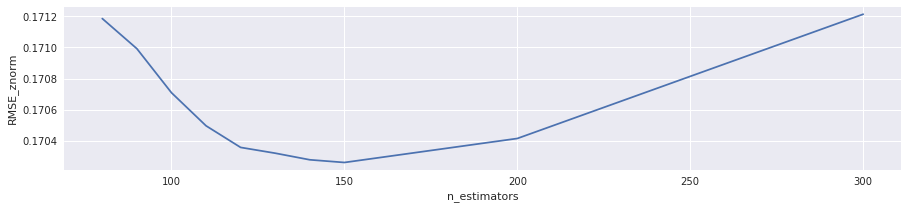

In [39]:
param_range = [80, 90, 100, 110, 120, 130, 140, 150, 200, 300]
print('Values to test ->', param_range)
param_name = 'n_estimators'
scores = []
for p in param_range:
    print('Validating', param_name, '=', p, end='\t')
    scores.append(-sklearn.model_selection.cross_val_score(xgb.XGBRegressor(learning_rate=0.1, n_estimators=p,
        max_depth=7, colsample_bylevel=0.592, reg_alpha=0.651, reg_lambda=2.84, seed=5555, objective=objective, n_jobs=-1),
                                                           X, np.log(2 + y) if log_target else y, cv=kf, scoring=scorer()).mean())
    print('score =', scores[-1])
pl.plot(param_range, scores)
pl.ylabel('RMSE_znorm')
pl.xlabel(param_name)

In [26]:
# params = {'max_depth': np.arange(3,9), 'reg_lambda': np.linspace(0.5, 1.5),
#           'colsample_bylevel': np.linspace(0.4, 1), 'min_child_weight': np.arange(1, 5),
#           'subsample': np.linspace(0.5, 1), 'colsample_bytree': np.linspace(0.8, 1),
#           'reg_alpha': np.linspace(0, 1)}
# clf_xgb = xgb.XGBRegressor(learning_rate=0.3, n_estimators=70, seed=555, n_jobs=-1)
# search = sklearn.model_selection.RandomizedSearchCV(clf_xgb, params, n_iter=20, scoring=sklearn.metrics.make_scorer(
#             lambda y, y_pred: -np.sqrt(np.mean(((y_pred - y)/(1 + y))**2))), cv=kf, verbose=2)
# search.fit(X, y)
# search.best_params_, search.best_score_

In [76]:
# results = search.cv_results_
# for p in params.keys():
#     pl.figure()
#     pl.scatter(results['param_' + p], -results['mean_test_score'])
#     pl.xlabel(p)
#     pl.ylabel('error')

#### bayesian optimization

In [33]:
def evaluate_xgb(max_depth, reg_lambda, reg_alpha,
                 colsample_bylevel, n_estimators):
    max_depth = int(round(max_depth))
    reg_lambda = max(reg_lambda, 0)
    reg_alpha = max(reg_alpha, 0)
    colsample_bylevel = min(max(colsample_bylevel, 0), 1)
    n_estimators = int(round(n_estimators))
    clf_xgb = xgb.XGBRegressor(max_depth=max_depth, learning_rate=0.1, n_estimators=n_estimators, min_child_weight=1,
                               reg_lambda=reg_lambda, reg_alpha=reg_alpha, colsample_bytree=1, n_jobs=-1,
                               colsample_bylevel=colsample_bylevel, subsample=1, seed=5555, objective=objective)
    return sklearn.model_selection.cross_val_score(
        clf_xgb, X, np.log(2 + y) if log_target else y, cv=kf, scoring=scorer()).mean()

In [ ]:
optimization = bayes_opt.BayesianOptimization(evaluate_xgb, {'max_depth': (3, 10),
                                                             'n_estimators': (70, 150),
                                                             'reg_lambda': (0.3, 15),
                                                             'reg_alpha': (0, 1),
                                                             'colsample_bylevel': (0.5, 1)})
optimization.maximize(init_points=5, n_iter=10)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   max_depth |   n_estimators |   reg_alpha |   reg_lambda | 
    1 | 19m45s |   -0.17225 |              0.7001 |     10.1589 |        81.7333 |      0.4351 |       1.9819 | 
    2 | 11m01s |   -0.17803 |              0.5842 |      5.2523 |        77.3608 |      0.5804 |      12.9191 | 
    3 | 28m27s |   -0.17974 |              0.5305 |     12.3236 |       122.7213 |      0.0279 |       7.5687 | 
    4 | 21m14s |   -0.17410 |              0.6098 |     11.3608 |        90.9637 |      0.1289 |       6.6385 | 
    5 | 40m53s |   -0.19275 |              0.8783 |     14.1832 |       117.7699 |      0.0564 |       3.1092 | 
    6 | 21m21s |   -0.17450 |              0.6468 |      4.8948 |       148.1281 |      0.1162 |      12.1184 | 
    7 | 31m39s |   -0.18896 |              0.7789 |     14.1910 |        95.0098 |

In [36]:
optimization.res['max']

{'max_params': {'colsample_bylevel': 0.59186865814108058,
  'max_depth': 7.143337670569359,
  'n_estimators': 123.52154231747841,
  'reg_alpha': 0.65167739808099301,
  'reg_lambda': 2.8466205107743332},
 'max_val': -0.1703586073203035}

# Galaxies only


In [19]:
crossval_metrics = pd.DataFrame(columns=['RMSE_znorm', 'bias_znorm', 'std_znorm', 'RMSE', '|znorm| > 0.15 (%)', '|znorm| > 3std (%)'])
for k, (train_index, validation_index) in enumerate(kf.split(X)):
    print('Fold', k)
    X_train, X_validation = X[train_index], X[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]
    
    clf_xgb = xgb.XGBRegressor(learning_rate=0.1, n_estimators=150,
                               max_depth=7, colsample_bylevel=0.592, reg_alpha=0.651,
                               reg_lambda=2.84, seed=5555, objective=objective, n_jobs=-1)
    
#     clf_rf = sklearn.ensemble.RandomForestRegressor(max_depth=25, n_estimators=20, n_jobs=-1)
#     clf_ada = sklearn.ensemble.AdaBoostRegressor()
    for clf, clf_name in zip([clf_xgb], ['XGB']):
#         scaler = StandardScaler()
#         pca = PCA(n_components=2, random_state=555)
#         clf.fit(np.hstack((X_train, pca.fit_transform(scaler.fit_transform(X_train)))), y_train)
#         y_pred = clf.predict(np.hstack((X_validation, pca.transform(scaler.transform(X_validation)))))
        
        clf.fit(X_train, np.log(2 + y_train) if log_target else y_train)
        y_pred = np.exp(clf.predict(X_validation)) - 2 if log_target else clf.predict(X_validation)
        
        crossval_metrics = crossval_metrics.append(compute_metrics(y_validation, y_pred, clf_name))
        for c in ['GALAXY']:
            mask = object_class[validation_index] == c
            crossval_metrics = crossval_metrics.append(
                compute_metrics(y_validation[mask], y_pred[mask], clf_name + ' (' + c + ' only)'))
#     crossval_metrics = crossval_metrics.append(compute_metrics(y_validation, y_sdss[validation_index], 'SDSS'))
crossval_metrics.groupby(crossval_metrics.index).mean()

Fold 0
Fold 1
Fold 2


,RMSE_znorm,bias_znorm,std_znorm,RMSE,|znorm| > 0.15 (%),|znorm| > 3std (%)
XGB,0.0316312,0.000103345,0.031631,0.0458429,0.589599,1.54223
XGB (GALAXY only),0.0316312,0.000103345,0.031631,0.0458429,0.589599,1.54223


In [20]:
clf_xgb.fit(X, np.log(2 + y) if log_target else y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.592,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=-1,
       objective=<function objective at 0x7f7664051730>, random_state=5555,
       reg_alpha=0.651, reg_lambda=2.84, scale_pos_weight=1, seed=5555,
       silent=True, subsample=1)

In [21]:
temp = pd.DataFrame(columns=['RMSE_znorm', 'bias_znorm', 'std_znorm', 'RMSE','|znorm| > 0.15 (%)', '|znorm| > 3std (%)'])
y_pred = np.exp(clf_xgb.predict(X_test)) - 2 if log_target else clf_xgb.predict(X_test)
temp = temp.append(compute_metrics(y_test, y_pred, 'XGB (galaxies only)'))
temp

,RMSE_znorm,bias_znorm,std_znorm,RMSE,|znorm| > 0.15 (%),|znorm| > 3std (%)
XGB (galaxies only),0.0314929,3.53884e-05,0.0314928,0.0457272,0.592555,1.5365


# </end GALAXIES

# Cross-validation

In [9]:
crossval_metrics = pd.DataFrame(columns=['RMSE_znorm', 'bias_znorm', 'std_znorm', 'RMSE', '|znorm| > 0.15 (%)', '|znorm| > 3std (%)'])
for k, (train_index, validation_index) in enumerate(kf.split(X)):
    print('Fold', k)
    X_train, X_validation = X[train_index], X[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]
    
    clf_xgb = xgb.XGBRegressor(learning_rate=0.1, n_estimators=150,
                               max_depth=7, colsample_bylevel=0.592, reg_alpha=0.651,
                               reg_lambda=2.84, random_state=5555, objective=objective, n_jobs=-1)
    
#     clf_rf = sklearn.ensemble.RandomForestRegressor(max_depth=25, n_estimators=20, n_jobs=-1)
#     clf_ada = sklearn.ensemble.AdaBoostRegressor(random_state=55)
    for clf, clf_name in zip([clf_xgb], ['XGB']):
#         scaler = StandardScaler()
#         pca = PCA(n_components=2, random_state=555)
#         clf.fit(np.hstack((X_train, pca.fit_transform(scaler.fit_transform(X_train)))), y_train)
#         y_pred = clf.predict(np.hstack((X_validation, pca.transform(scaler.transform(X_validation)))))
        
        clf.fit(X_train, np.log(2 + y_train) if log_target else y_train)
        y_pred = np.exp(clf.predict(X_validation)) - 2 if log_target else clf.predict(X_validation)
        
        crossval_metrics = crossval_metrics.append(compute_metrics(y_validation, y_pred, clf_name))
        for c in class_order:
            mask = object_class[validation_index] == c
            crossval_metrics = crossval_metrics.append(
                compute_metrics(y_validation[mask], y_pred[mask], clf_name + ' (' + c + ' only)'))
#     crossval_metrics = crossval_metrics.append(compute_metrics(y_validation, y_sdss[validation_index], 'SDSS'))
crossval_metrics.groupby(crossval_metrics.index).mean()

Fold 0
Fold 1
Fold 2


,RMSE_znorm,bias_znorm,std_znorm,RMSE,|znorm| > 0.15 (%),|znorm| > 3std (%)
XGB,0.168985,0.00151906,0.168978,0.39789,10.7687,2.95263
XGB (GALAXY only),0.0547475,-0.00101521,0.0547379,0.0724834,1.33523,1.1241
XGB (QSO only),0.300311,-0.16076,0.253657,1.08191,52.3015,0.437383
XGB (STAR only),0.266832,0.0954318,0.249182,0.266804,16.5048,3.47943


In [8]:
clf_xgb = xgb.XGBRegressor(learning_rate=0.1, n_estimators=150,
                               max_depth=7, colsample_bylevel=0.592, reg_alpha=0.651,
                               reg_lambda=2.84, seed=5555, objective=objective, n_jobs=-1)
    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


## linear PCA

In [15]:
scaler = StandardScaler()
pca = PCA(random_state=555)
X_pca = pca.fit_transform(scaler.fit_transform(X))

In [81]:
# pl.figure(figsize=(15,15))
# pd.Series(pca.components_[0], index=columns).sort_values().plot(kind='barh')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


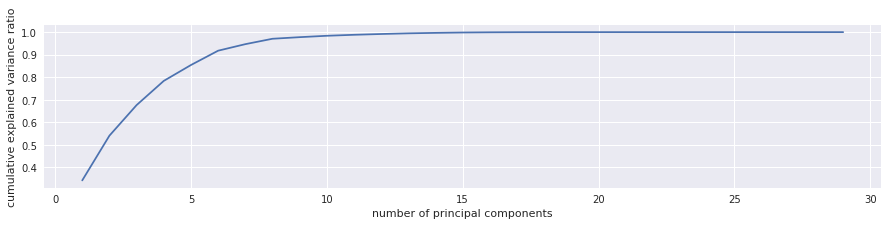

In [16]:
pl.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum())
pl.ylabel('cumulative explained variance ratio')
pl.xlabel('number of principal components')
# pl.xlim(1, 25)

# Prediction

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


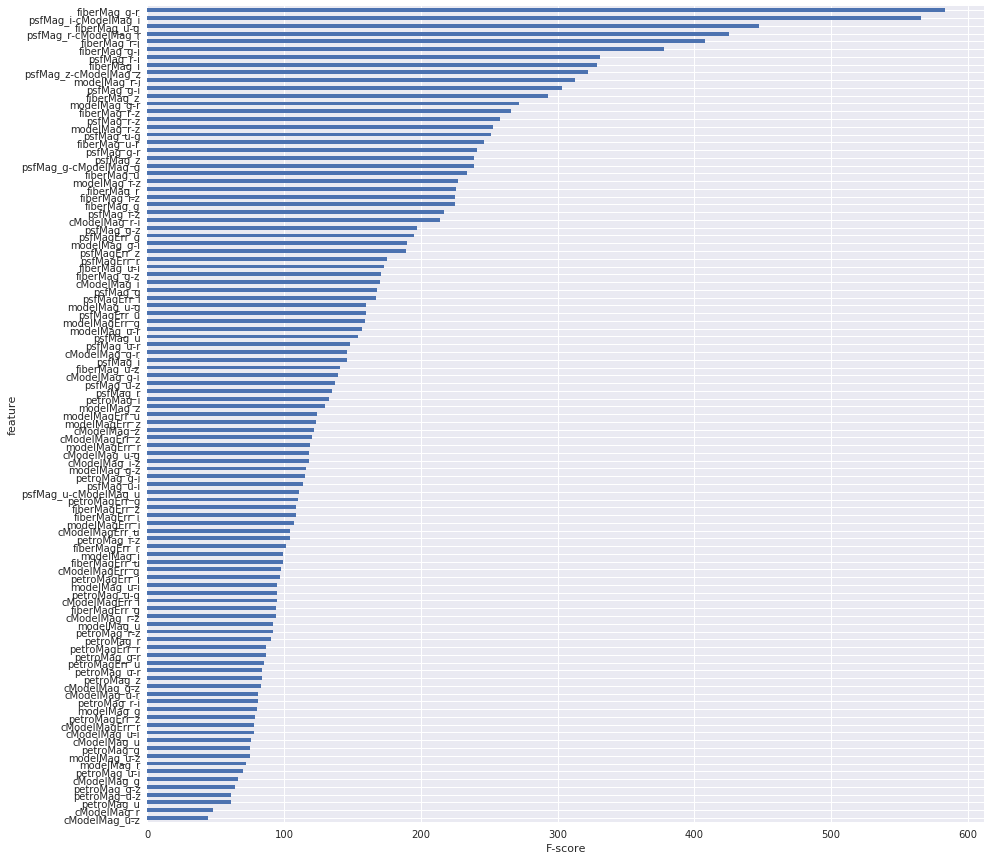

In [9]:
clf_xgb.fit(X, np.log(2 + y) if log_target else y)
dict_column_names = {'f' + str(i) : c for i, c in enumerate(columns)}
feature_importance = pd.Series(clf_xgb.get_booster().get_fscore()).reset_index().rename(columns={'index': 'feature'})
feature_importance.feature = feature_importance.feature.map(dict_column_names)
feature_importance = feature_importance.set_index('feature')[0].sort_values()
feature_importance.plot(kind='barh', figsize=(15,15))
pl.xlabel('F-score')

In [ ]:
temp = pd.DataFrame(columns=['RMSE_znorm', 'bias_znorm', 'std_znorm', 'RMSE','|znorm| > 0.15 (%)', '|znorm| > 3std (%)'])
y_pred = np.exp(clf_xgb.predict(X_test)) - 2 if log_target else clf_xgb.predict(X_test)
temp = temp.append(compute_metrics(y_test, y_pred, 'XGB'))
for c in class_order:
    mask = object_class_test == c
    temp = temp.append(compute_metrics(y_test[mask], y_pred[mask], 'XGB' + ' (' + c + ' only)'))
# temp = temp.append(compute_metrics(y_test, y_sdss_test, 'SDSS'))
temp

,RMSE_znorm,bias_znorm,std_znorm,RMSE,|znorm| > 0.15 (%),|znorm| > 3std (%)
XGB,0.167846,0.0011417,0.167842,0.398493,10.7778,2.97108
XGB (GALAXY only),0.0534627,-0.00112573,0.0534509,0.0710441,1.31791,1.15514
XGB (STAR only),0.264443,0.0947871,0.246872,0.264413,16.5527,3.4573
XGB (QSO only),0.300709,-0.161281,0.2538,1.08486,52.4108,0.432742


# Using n-features

In [2]:
losses = []
f_indices = [columns.get_loc(f) for f in feature_importance.sort_values(ascending=False).index]
print(f_indices)
for order, f_i in enumerate(f_indices):
    if order < 4:
        continue
    loss = -sklearn.model_selection.cross_val_score(
        clf_xgb, X[:, f_indices[:order+1]], 
        np.log(2 + y) if log_target else y, cv=kf, scoring=scorer()).mean()
    print('using first', order+1, '( up to', columns[f_i], ') loss is', loss)
    losses.append(loss)

In [ ]:
losses = pd.Series(losses)
losses.index += 5

In [ ]:
pd.Series(losses).to_csv('n_features_rmse.csv')

In [ ]:
losses.plot()
pl.xlabel('Using first n important features')
pl.ylabel('RMSE')

In [ ]:
most_important_features = pd.Series(feature_importance.sort_values(ascending=False).iloc[:29].index)
most_important_features.to_csv('most_important_features.csv')

# Feature selection

In [23]:
best_loss = -sklearn.model_selection.cross_val_score(
        clf_xgb, X, np.log(2 + y) if log_target else y, cv=kf, scoring=scorer()).mean() #crossval_metrics.ix['XGB', 'RMSE_znorm'].mean()
to_delete = []
changes = pd.Series()
print('Columns to delete:')
for c in list(feature_importance.sort_values().index):
    i = columns.get_loc(c)
    loss = -sklearn.model_selection.cross_val_score(
        clf_xgb, X[:, [x for x in range(X.shape[1]) if x not in to_delete + [i]]], 
        np.log(2 + y) if log_target else y, cv=kf, scoring=scorer()).mean()
    changes.loc[c] = loss - best_loss
    if changes.loc[c] < 0:
        to_delete.append(i)
        print(c, ': DEL')
    else:
        print(c, ': OK', changes.loc[c])

In [ ]:
pl.figure(figsize=(15,20))
changes.sort_values().plot(kind='barh')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


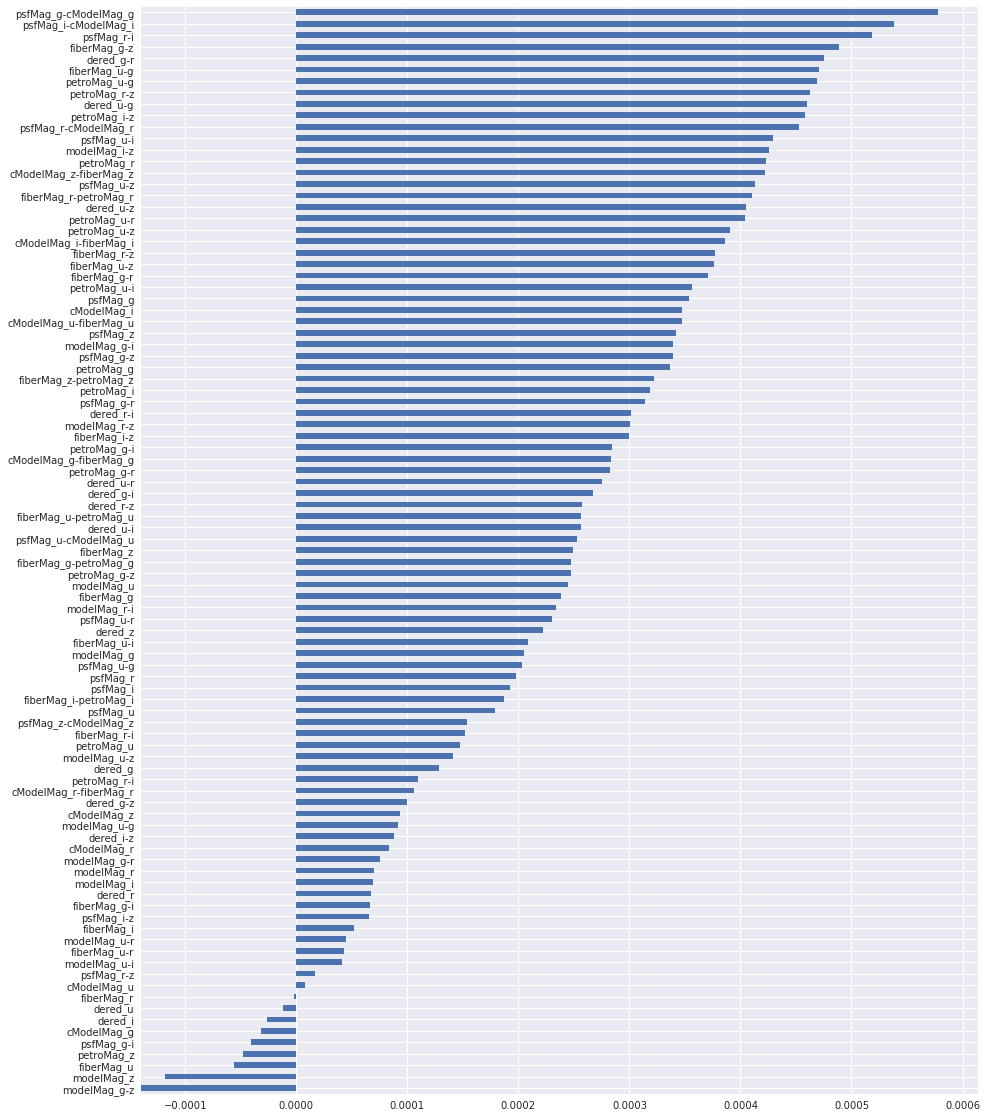

In [21]:
pl.figure(figsize=(15,20))
changes.sort_values().plot(kind='barh')

In [18]:
# changes.to_csv('feature_changes.csv')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


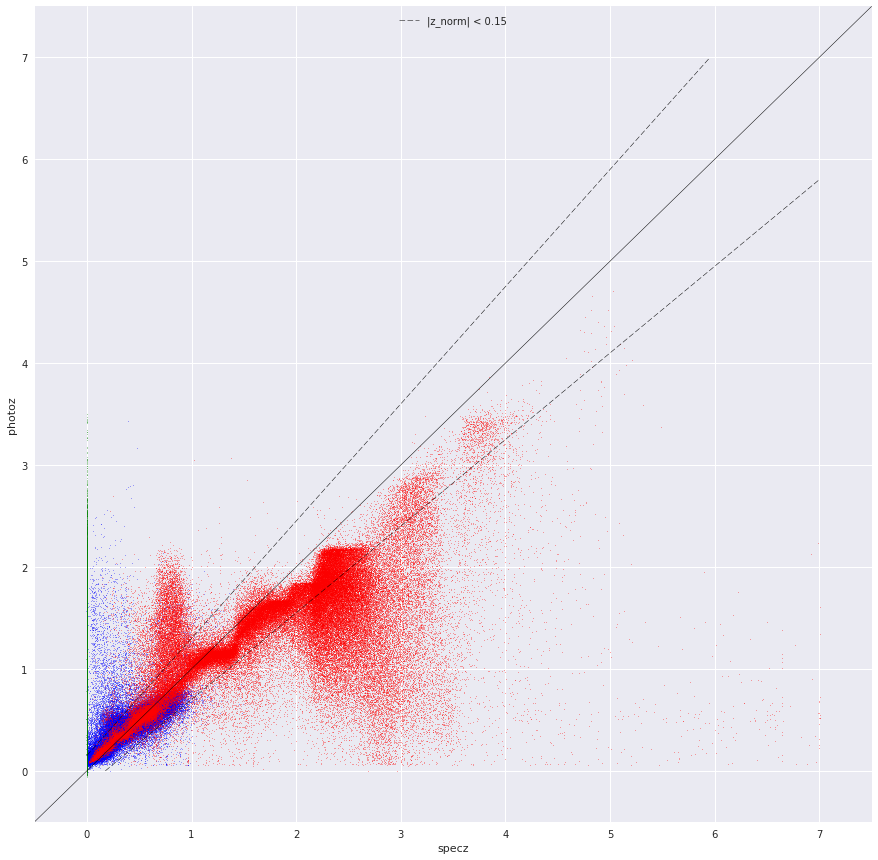

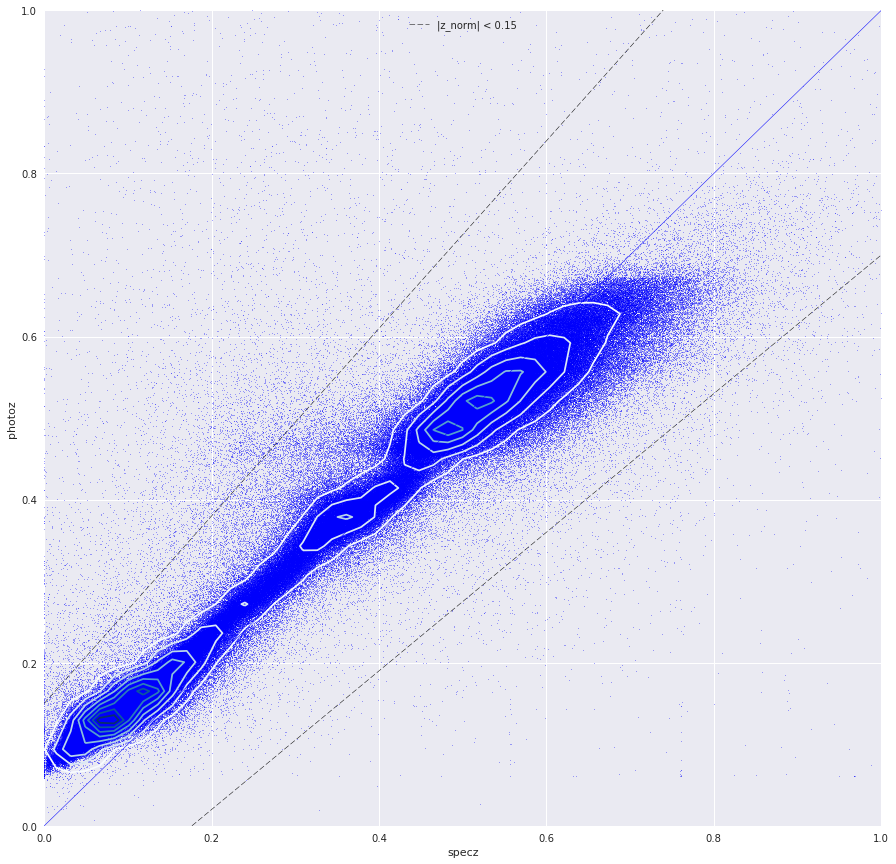

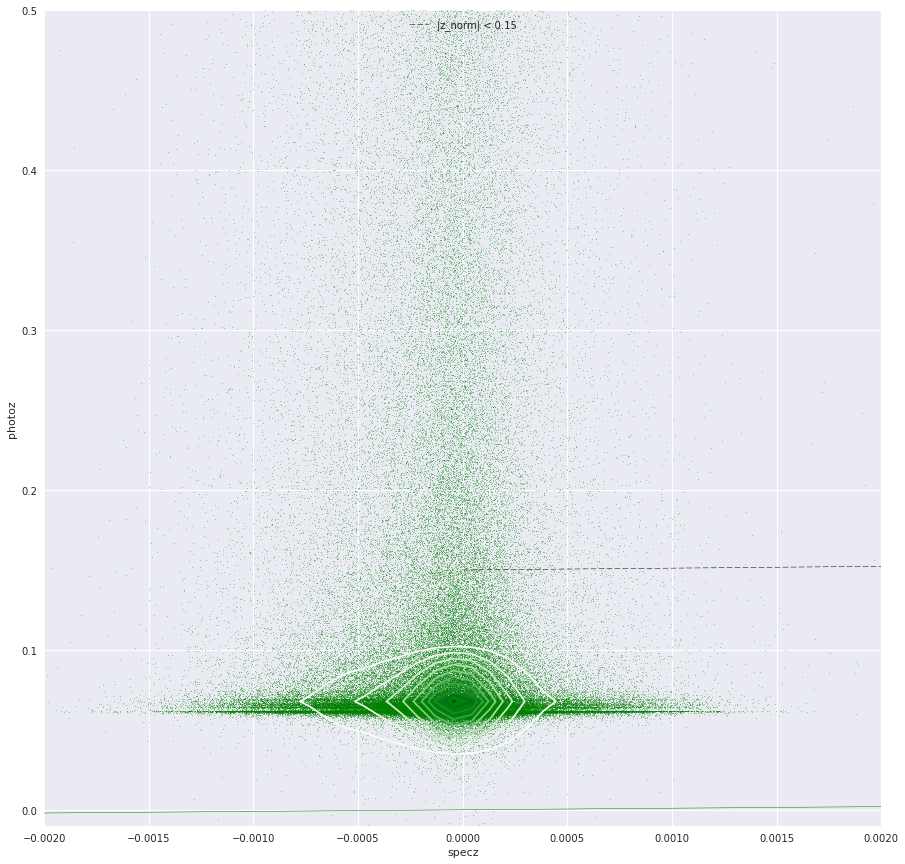

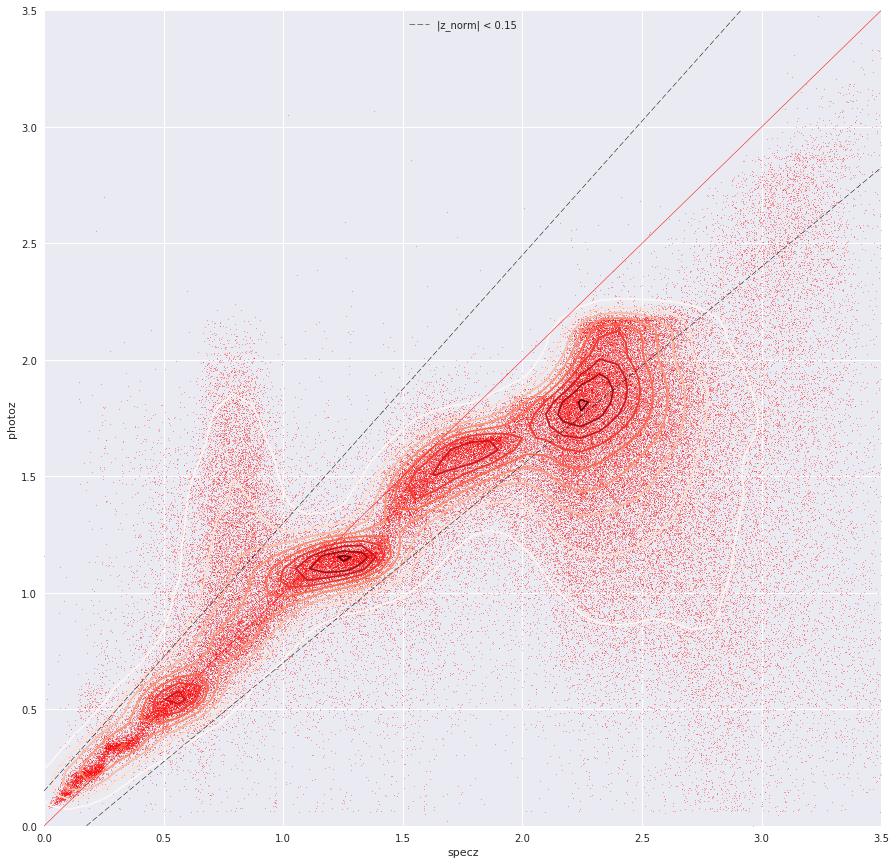

In [26]:
pl.figure(figsize=(15, 15))
# sns.kdeplot(y_test, y_pred, gridsize=100, n_levels=5, cmap='gray')
pl.plot([-0.5, 7.5], [-0.5, 7.5], c='k', linewidth=0.5)
pl.ylim(-0.5, 7.5)
pl.xlim(-0.5, 7.5)
pl.plot([0.15/0.85, 7], [0, 0.85*7 - 0.15], '--', c='k', linewidth=0.5, label='|z_norm| < 0.15')
pl.plot([0, (7-0.15)/1.15], [0.15, 7], '--', c='k', linewidth=0.5)
pl.legend(loc='upper center')
for c, color in zip(class_order, ['b', 'g', 'r']):
    pl.scatter(y_test[object_class_test == c], y_pred[object_class_test == c], c=color, s=0.1)
    pl.xlabel('specz')
    pl.ylabel('photoz')
    
for c, color, cmap, (x_min, x_max), (y_min, y_max) in zip(class_order, ['b', 'g', 'r'], ['Blues', 'Greens', 'Reds'],
                                                          [(0, 1), (-0.002, 0.002), (0, 3.5)], [(0, 1), (-0.01, 0.5), (0, 3.5)]):    
    pl.figure(figsize=(15, 15))
    pl.scatter(y_test[object_class_test == c], y_pred[object_class_test == c], c=color, s=0.1)
    sns.kdeplot(y_test[object_class_test == c], y_pred[object_class_test == c], gridsize=100, n_levels=10, cmap=cmap)
    pl.xlabel('specz') 
    pl.ylabel('photoz')
    pl.plot([-0.5, 7.5], [-0.5, 7.5], c=color, linewidth=0.5)
    pl.ylim(y_min, y_max)
    pl.xlim(x_min, x_max)
    pl.plot([0.15/0.85, 7], [0, 0.85*7 - 0.15], '--', c='k', linewidth=0.5, label='|z_norm| < 0.15')
    pl.plot([0, (7-0.15)/1.15], [0.15, 7], '--', c='k', linewidth=0.5)
    pl.legend(loc='upper center')

In [ ]:
# pl.figure(figsize=(7*2,7))
# for i, (y, name) in enumerate(zip([y_sdss_test, y_pred], ['SDSS', 'XGB'])):    
#     pl.subplot(1, 2, i + 1)
#     pl.title(name)
#     pl.scatter(y_test, y, c='r', s=0.02)
#     sns.kdeplot(y_test, y, gridsize=100, n_levels=10)
#     pl.xlim(0, 1)
#     pl.ylim(0, 1)
#     pl.plot([0, 1], [0, 1])
#     pl.xlabel('specz')
#     pl.ylabel('photoz')